In [2]:
import h5py
import matplotlib.pyplot as plt
import mpl_lego as mplego
import neuropacks as packs
import numpy as np
import os
from scipy.stats import norm

from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from mpl_lego.ellipse import plot_cov_ellipse
from noise_correlations import analysis, utils

In [3]:
mplego.style.use_latex_style()
ccycle = mplego.colors.get_default_ccycle()

In [7]:
base_path = "/storage/noise_correlations/exp09"

In [8]:
pvc11_1_path = os.path.join(base_path, 'exp09_1_pvc11_15_1000_1000.h5')
pvc11_2_path = os.path.join(base_path, 'exp09_2_pvc11_15_1000_1000.h5')
pvc11_3_path = os.path.join(base_path, 'exp09_3_pvc11_15_1000_1000.h5')
ret2_path = os.path.join(base_path, 'exp09_ret2_15_1000_1000.h5')
ecog_path = os.path.join(base_path, 'exp09_ecog_15_3000_1000.h5')

In [9]:
pvc11_1 = h5py.File(pvc11_1_path, 'r')
#pvc11_2 = h5py.File(pvc11_2_path, 'r')
#pvc11_3 = h5py.File(pvc11_3_path, 'r')
#ret2 = h5py.File(ret2_path, 'r')
#ecog = h5py.File(ecog_path, 'r')
#results = [pvc11_1, pvc11_2, pvc11_3, ret2, ecog]
n_max_units = pvc11_1['units'].shape[2]
dims = 3 + np.arange(n_max_units - 2)

In [51]:
def plot_marginals(mu, cov, lim, pcts, ax, compare=True, denom=.3):
    marginal_pdf0 = norm(loc=mu[0], scale=np.sqrt(cov[0, 0]))
    marginal_pdf1 = norm(loc=mu[1], scale=np.sqrt(cov[1, 1]))
    v0 = marginal_pdf0.cdf(pcts[0])
    v1 = marginal_pdf1.cdf(pcts[1])
    xs = np.linspace(lim[0], lim[1], 4800)
    idxs = xs < pcts[0]
    ys0 = marginal_pdf0.pdf(xs)
    ys1 = marginal_pdf1.pdf(xs)
    ax.plot(xs, -ys0 * lim[0] / denom + lim[0], c='k')
    c = 'gray'
    if compare:
        if v0 > v1:
            ax.text(mu[0] - 7, -5, r'$\textbf{END}$', size=20)
            c = 'dimgray'
        else:
            ax.text(-5, mu[1] - 7, r'$\textbf{END}$', size=20)
            c = 'lightgray'
    ax.fill_between(xs[idxs], lim[0]*np.ones_like(xs[idxs]),
                    -ys0[idxs] * lim[0] / denom + lim[0], fc=c, alpha=1)
    idxs = xs < pcts[1]
    ys = marginal_pdf1.pdf(xs)
    ax.plot(-ys1 * lim[0] / denom + lim[0], xs,c='k')
    if compare:
        if v0 > v1:
            c = 'lightgray'
        else:
            c = 'dimgray'
    ax.fill_betweenx(xs[idxs], lim[0]*np.ones_like(xs[idxs]),
                    -ys1[idxs] * lim[0] / denom + lim[0], fc=c, alpha=1)

def plot_fano(mu, cov, ax):
    ax.errorbar(23, mu[1],
                yerr=[np.sqrt(cov[1, 1])], c='k',
                capsize=5, capthick=3, elinewidth=3,
                marker='o', ms=10)
    ax.text(24, mu[1], r'$\textbf{FF}_2$', size=20)
    ax.text(mu[0], 24, r'$\textbf{FF}_1$', size=20)
    ax.errorbar(mu[0], 23,
                xerr=[np.sqrt(cov[0, 0])], c='k',
                capsize=5, capthick=3, elinewidth=3,
                marker='o', ms=10)

def plot_obs_marginals(X, lim, ax):
    bins = np.linspace(0, lim[1], lim[1]+1)
    hist0, bin_edges = np.histogram(X[:, 0], bins=bins)
    hist1, bin_edges = np.histogram(X[:, 1], bins=bins)
    hmax = max(hist0.max(), hist1.max())
    ax.plot(bins[:-1], -hist0 *lim[0] / hmax + lim[0], c='gray', ds='steps-post')
    ax.plot(-hist1 *lim[0] / hmax + lim[0], bins[:-1], c='gray', ds='steps-pre')

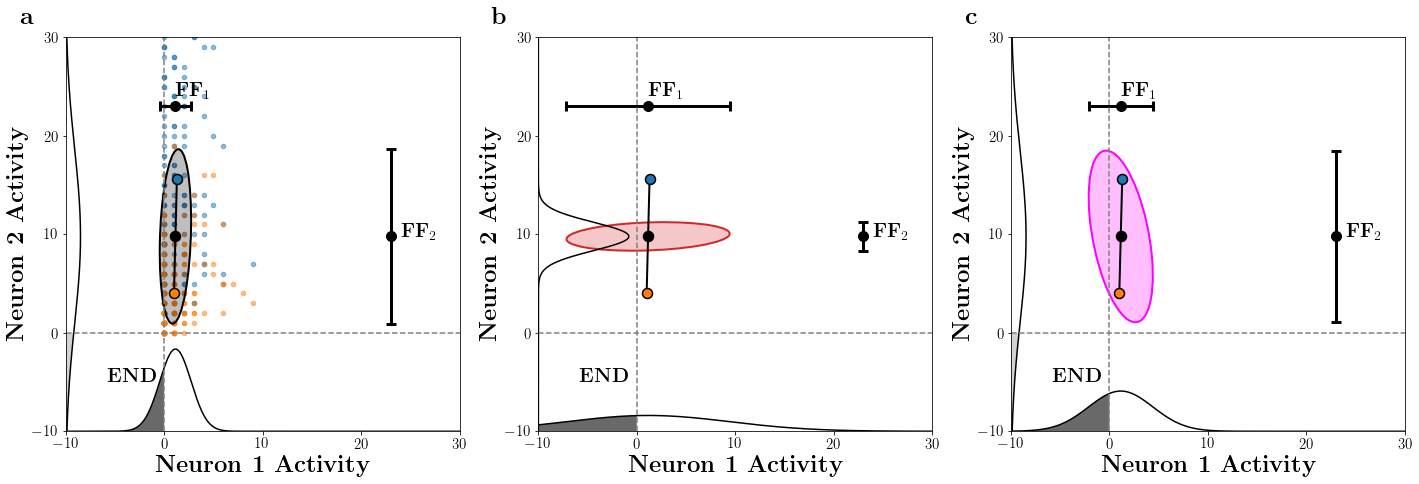

In [53]:
fig, axes = plt.subplots(1, 3, figsize=(24, 8))
idx = 3695
units = pvc11_1['units'][0, idx][:2]
Xu = pvc11_1['X'][:][:, units]
pcts = np.percentile(Xu, 1, axis=0)
opt = pvc11_1['opt_covs/3'][idx]
opt_fa = pvc11_1['opt_fa_covs/3'][idx]
X1, X2 = utils.get_dimstim_responses_from_h5(pvc11_1, 0, idx)
cov1 = np.cov(X1.T)
cov2 = np.cov(X2.T)
obs = 0.5 * (cov1 + cov2)
mu1 = np.mean(X1, axis=0)
mu2 = np.mean(X2, axis=0)
avg_mean = 0.5 * (mu1 + mu2)

neuron1 = 0
neuron2 = 1
slc = [neuron1, neuron2]
lim = [-10, 30]

ax = axes[0]
# Plot the neural responses, stimulus 1
ax.scatter(
    X1[:, neuron1], X1[:, neuron2],
    marker='o',
    color='C0',
    alpha=0.5,
    s=20)


# Plot the neural responses, stimulus 2
ax.scatter(
    X2[:, neuron1], X2[:, neuron2],
    marker='o',
    color='C1',
    alpha=0.5,
    s=20)


# Plot observed covariance ellipse
plot_cov_ellipse(
    obs,
    avg_mean[[neuron1, neuron2]],
    ax,
    include_mu=False,
    n_std=1,
    linewidth=2,
    facecolor=mplego.colors.hex_to_rgb('#000000', 0.25),
    edgecolor=mplego.colors.hex_to_rgb('#000000', 1.0))
plot_marginals(avg_mean[[neuron1, neuron2]],
               obs,
               lim, pcts, ax)
plot_fano(avg_mean[[neuron1, neuron2]],
               obs, ax)


ax = axes[1]
# Plot optimal covariance ellipse
plot_cov_ellipse(
    opt[[neuron1, neuron2]][:, [neuron1, neuron2]],
    avg_mean[[neuron1, neuron2]],
    ax,
    include_mu=False,
    n_std=1,
    linewidth=2,
    facecolor=mplego.colors.hex_to_rgb(ccycle[3], 0.25),
    edgecolor=mplego.colors.hex_to_rgb(ccycle[3], 1.0))
plot_marginals(avg_mean[[neuron1, neuron2]],
               opt[[neuron1, neuron2]][:, [neuron1, neuron2]],
               lim, pcts, ax, compare=True)
plot_fano(avg_mean[[neuron1, neuron2]],
               opt[[neuron1, neuron2]][:, [neuron1, neuron2]], ax)


ax = axes[2]
# Plot optimal FA covariance ellipse
plot_cov_ellipse(
    opt_fa[[neuron1, neuron2]][:, [neuron1, neuron2]],
    avg_mean[[neuron1, neuron2]],
    ax,
    include_mu=False,
    n_std=1,
    linewidth=2,
    facecolor=mplego.colors.hex_to_rgb('#FF00FF', 0.25),
    edgecolor=mplego.colors.hex_to_rgb('#FF00FF', 1.0))
plot_marginals(avg_mean[[neuron1, neuron2]],
               opt_fa[[neuron1, neuron2]][:, [neuron1, neuron2]],
               lim, pcts, ax, compare=True)
plot_fano(avg_mean[[neuron1, neuron2]],
               opt_fa[[neuron1, neuron2]][:, [neuron1, neuron2]], ax)


labels = ['a', 'b', 'c']
for ii, ax in enumerate(axes):
    # Plot the differential correlation direction
    ax.plot(
        [mu1[0], mu2[0]], [mu1[neuron2], mu2[neuron2]],
        linewidth=2,
        color='black')
    # Plot the mean, stimulus 1
    ax.scatter(
        mu1[neuron1], mu1[neuron2],
        color='C0',
        edgecolor='black',
        linewidth=1.5,
        s=100,
        zorder=1000)
    # Plot the mean, stimulus 2
    ax.scatter(
        mu2[neuron1], mu2[neuron2],
        color='C1',
        edgecolor='black',
        linewidth=1.5,
        s=100,
        zorder=1000)
    # Plot the average mean
    ax.scatter(
        avg_mean[neuron1], avg_mean[neuron2],
        color='black',
        edgecolor='black',
        linewidth=1.5,
        s=100,
        zorder=1000)
    # Indicate the axes
    ax.axvline(0, linestyle='--', color='gray')
    ax.axhline(0, linestyle='--', color='gray')

    mplego.scatter.tighten_scatter_plot(ax, lim=lim, identity=False)

    ax.set_xlabel(r'\textbf{Neuron 1 Activity}', fontsize=24)
    ax.set_ylabel(r'\textbf{Neuron 2 Activity}', fontsize=24)
    ax.set_xticks([-10, 0, 10, 20, 30])
    ax.set_yticks([-10, 0, 10, 20, 30])
    ax.tick_params(labelsize=15)
mplego.labels.apply_subplot_labels(axes, x=-0.1, size=25, bold=True)
plt.savefig('figure4.jpg', bbox_inches='tight')
plt.savefig('figure4.pdf', bbox_inches='tight')